# Progetto 7 : "Giro del Mondo in 80 (anche meno) giorni" 

In [1]:
import numpy as np
import pandas as pd
import math
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import geopandas
from geopy import distance
import networkx as nx
from haversine import haversine, Unit
from networkx.algorithms.shortest_paths.generic import has_path
from networkx.algorithms.shortest_paths.weighted import dijkstra_path, dijkstra_path_length
from sklearn.neighbors import BallTree
import folium

## Dati di lavoro

### Caricamento, analisi e trasformazione

In [2]:
cities = pd.read_excel('./worldcities.xlsx')

In [3]:
cities

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Tokyo,Tokyo,35.6897,139.6922,Japan,JP,JPN,Tōkyō,primary,37977000.0,1392685764
1,Jakarta,Jakarta,-6.2146,106.8451,Indonesia,ID,IDN,Jakarta,primary,34540000.0,1360771077
2,Delhi,Delhi,28.6600,77.2300,India,IN,IND,Delhi,admin,29617000.0,1356872604
3,Mumbai,Mumbai,18.9667,72.8333,India,IN,IND,Mahārāshtra,admin,23355000.0,1356226629
4,Manila,Manila,14.5958,120.9772,Philippines,PH,PHL,Manila,primary,23088000.0,1608618140
...,...,...,...,...,...,...,...,...,...,...,...
26564,Nord,Nord,81.7166,-17.8000,Greenland,GL,GRL,Sermersooq,NaN,10.0,1304217709
26565,Timmiarmiut,Timmiarmiut,62.5333,-42.2167,Greenland,GL,GRL,Kujalleq,NaN,10.0,1304206491
26566,Cheremoshna,Cheremoshna,51.3894,30.0989,Ukraine,UA,UKR,Kyyivs’ka Oblast’,NaN,0.0,1804043438
26567,Ambarchik,Ambarchik,69.6510,162.3336,Russia,RU,RUS,Sakha (Yakutiya),NaN,0.0,1643739159


In [4]:
cities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26569 entries, 0 to 26568
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   city        26569 non-null  object 
 1   city_ascii  26569 non-null  object 
 2   lat         26569 non-null  float64
 3   lng         26569 non-null  float64
 4   country     26569 non-null  object 
 5   iso2        26538 non-null  object 
 6   iso3        26569 non-null  object 
 7   admin_name  26493 non-null  object 
 8   capital     7626 non-null   object 
 9   population  25596 non-null  float64
 10  id          26569 non-null  int64  
dtypes: float64(3), int64(1), object(7)
memory usage: 2.2+ MB


In [5]:
city_Matrix=np.array(cities.loc[:,('city','lat','lng', 'iso3', 'population' )])

In [6]:
Loc_start = ['London','GBR']  # Ci sono più Londra tra le città
Start_city=[]

for i, v in enumerate(city_Matrix):
    for k, p in enumerate(v):
        if p == Loc_start[0] and city_Matrix[i,k+3]== Loc_start[1]:
#             print(i,k,p)
            Start_city.append(city_Matrix[i,k])
            Start_city.append(city_Matrix[i,k+1])
            Start_city.append(city_Matrix[i,k+2])
            Start_city.append(city_Matrix[i,k+3])
            Start_city.append(city_Matrix[i,k+4])
                   
print(Loc_start)
print(f"{Start_city}") # Dati di Londra

['London', 'GBR']
['London', 51.5072, -0.1275, 'GBR', 10979000.0]


In [7]:
# aggiungo 360° alla longitudine delle città con longitudine minore di Londra (punto di partenza) per poi ordinarle
for i,x in enumerate(cities.values):
    if x[3]<Start_city[2]:
        cities.iloc[i,3]+=360
    else:
        pass

In [8]:
df = cities.sort_values(by =['lng']) # le ordino da est ad ovest (per longitudine crescente)
df

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
34,London,London,51.5072,-0.1275,United Kingdom,GB,GBR,"London, City of",primary,10979000.0,1826645935
6778,Southgate,Southgate,51.6316,-0.1265,United Kingdom,GB,GBR,Enfield,NaN,14454.0,1826679961
13007,Burgess Hill,Burgess Hill,50.9535,-0.1262,United Kingdom,GB,GBR,West Sussex,NaN,30635.0,1826867983
5119,Streatham,Streatham,51.4279,-0.1235,United Kingdom,GB,GBR,Lambeth,NaN,58055.0,1826845701
20410,Ramsey,Ramsey,52.4500,-0.1200,United Kingdom,GB,GBR,Cambridgeshire,NaN,8479.0,1826625567
...,...,...,...,...,...,...,...,...,...,...,...
13806,Coulsdon,Coulsdon,51.3211,359.8614,United Kingdom,GB,GBR,Croydon,NaN,25695.0,1826373748
20408,Bogandé,Bogande,12.9690,359.8620,Burkina Faso,BF,BFA,Est,minor,9854.0,1854811035
10205,Benidorm,Benidorm,38.5342,359.8686,Spain,ES,ESP,Valencia,NaN,68721.0,1724178356
3664,Brighton,Brighton,50.8429,359.8687,United Kingdom,GB,GBR,Brighton and Hove,NaN,134293.0,1826609057


### Aggiunta di Londra (e altre 299 città) come ultima città

In [9]:
df=df.append(df.iloc[0:300,:])
df.iloc[-300:,3]+=360

## Definizione misure di distanza

In [10]:
# Funzione di distanza haversine modificata affinché restituisca valori solo se la città di destinazione è ad est della città di partenza
def hav_dist(x,y):
    if x[1]>=y[1] or y[1]-x[1]>179:
        return np.nan
    else: return haversine(x, y)
have = lambda x, y: hav_dist(x,y)

In [11]:
have((51.5072,10),(51.6316,60))

3386.905240801647

In [12]:
# Funzione di distanza haversine modificata affinché calcoli le distanze delle città sia più a sud che più a nord indipendentemente dalla direzione est-ovest
def hav_dist2(x,y):
    if x[0]<=y[0] or (x[0]==y[0] and x[1]==y[1]):
        return np.nan
    else: return haversine(x, y)
have2 = lambda x, y: hav_dist2(x,y)

In [13]:
have2((51.5072,-0.1275),(51.5072,-0.1275))

nan

## Calcolo delle tre città più vicine

### 1° Parte con calcolo distanza solo verso est

In [14]:
N2=BallTree(df.iloc[:,2:4], leaf_size=40, metric=have)
B2 = N2.query(df.iloc[:,2:4], k=3, return_distance=True)

In [15]:
B2

(array([[1.28476784e+00, 1.96305324e+00, 3.78049620e+00],
        [1.94444503e+00, 3.81016817e+00, 3.89764370e+00],
        [6.03858167e+00, 7.31643491e+00, 1.59478011e+01],
        ...,
        [3.42549064e+00, 1.28500462e+03,            inf],
        [1.28205711e+03,            inf,            inf],
        [           inf,            inf,            inf]]),
 array([[    6,     5,    29],
        [   11,     8,    25],
        [   17,    21,    95],
        ...,
        [26868, 26867,     0],
        [26868,     0,     0],
        [    0,     0,     0]], dtype=int64))

### 2° Parte con calcolo distanza non solo verso est

In [16]:
N=BallTree(df.iloc[24500:,2:4], leaf_size=40, metric=have2)
B = N.query(df.iloc[24500:,2:4], k=3, return_distance=True)

In [17]:
B

(array([[ 14.16016588,  23.02199022,  27.13559128],
        [ 61.39298186,  72.58948206,  78.50377661],
        [ 14.88501396,  21.36295152,  22.58471925],
        ...,
        [  1.75170491,   3.42549064,   8.9808888 ],
        [168.20408021, 173.76906124, 177.41618876],
        [  7.20973635,  12.61598766,  29.9531991 ]]),
 array([[  34,   53,   31],
        [  38,   73,  103],
        [   4,   51,   41],
        ...,
        [2364, 2368, 2360],
        [2107, 2085, 2089],
        [2360, 2349, 2313]], dtype=int64))

## Calcolo distanze e creazione Grafo orientato

In [18]:
# Inserimento nel grafo solo delle città fino alla 24500-esima cosicché possa poi applicare sulle restanti la seconda funzione 
# di distanza che è meno vincolata
T = nx.DiGraph()
for i in range(24500):
    for k in range(3):
        
        if math.isinf(B2[0][i][k]) or B2[1][i][k] == 0:
            pass
        elif k < 2:
                      
            dist = 2+ 2*k
            if df.iloc[i,6]!=df.iloc[B2[1][i][k],6]:
                dist += 2
            if df.iloc[B2[1][i][k],-2]>200000:
                dist += 2
            T.add_node(B2[1][i][k])
            T.add_edge(i, B2[1][i][k], weight = dist)
        else:
            dist = 8
            if df.iloc[i,6]!=df.iloc[B2[1][i][k],6]:
                dist += 2
            if df.iloc[B2[1][i][k],-2]>200000:
                dist += 2
            T.add_node(B2[1][i][k])
            T.add_edge(i, B2[1][i][k], weight = dist)       


In [19]:
T.number_of_nodes()

24565

In [20]:
# Aggiunta della seconda parte di città dalla 24500-esima in poi
for i in range(len(B[0])):
    for k in range(3):
        
        if math.isinf(B[0][i][k]) or B[1][i][k] == 0:
            pass
        elif k < 2:
                      
            dist = 2+ 2*k
            if df.iloc[i+24500,6]!=df.iloc[B[1][i][k]+24500,6]:
                dist += 2
            if df.iloc[B[1][i][k]+24500,-2]>200000:
                dist += 2
            T.add_node(B[1][i][k]+24500)
            T.add_edge(i+24500, B[1][i][k]+24500, weight = dist)
        else:
            dist = 8
            if df.iloc[i+24500,6]!=df.iloc[B[1][i][k]+24500,6]:
                dist += 2
            if df.iloc[B[1][i][k]+24500,-2]>200000:
                dist += 2
            T.add_node(B[1][i][k]+24500)
            T.add_edge(i+24500, B[1][i][k]+24500, weight = dist)


In [21]:
T.number_of_nodes()

26869

## Esiste un percorso da Londra per tornare a Londra?

In [22]:
# Definisco una funzione per estrarre l'indice posizionale della città di partenza ed di arrivo (che in questo caso coincidono)
# nel dataframe e quindi il conseguente vertice del grafo

def city(x, s):
    towns=[]
    for i, v in enumerate(np.array(df)):
        if v[0] == x and v[6] == s:
            towns.append(i)
    return towns


In [23]:
start, arrival = city('London','GBR')

In [24]:
has_path(T,start, arrival)

True

## Calcolo itinerario più breve

### Percorso

In [25]:
def journey (partenza, arrivo):
    O = dijkstra_path(T, source=partenza, target=arrivo, weight='weight')
    return df.iloc[O,[0]]

In [26]:
journey(start, arrival)

,city
34,London
7432,Lambeth
4675,Brixton
5447,Catford
4685,Bromley
...,...
7425,Snaresbrook
6419,Leyton
6559,Hackney
6407,Stepney


### Durata Percorso

In [27]:
def length(partenza, arrivo):
    total = dijkstra_path_length(T, source=partenza, target=arrivo, weight='weight') - 24 # Fuso-orario
    days = total//24
    hours = total % 24
    return print('Total time length: {} hours of travel, that is {} days and {} hours'.format(total, days, hours))

In [28]:
length(start, arrival)

Total time length: 1064 hours of travel, that is 44 days and 8 hours


### Itinerario percorso e tempo di percorrenza

In [29]:
O = dijkstra_path(T, source=start, target=arrival, weight='weight')
for i in range(len(O)):
    if i < (len(O) - 1):
        print (df.iloc[O[i],0])
        print('Travel time: {}'.format(T[O[i]][O[i+1]]['weight']))
    if i == len(O)-1:
        print(df.iloc[O[i],0])

London
Travel time: 4
Lambeth
Travel time: 4
Brixton
Travel time: 2
Catford
Travel time: 8
Bromley
Travel time: 2
Bickley
Travel time: 8
Farnborough
Travel time: 2
Chelsfield
Travel time: 4
Sevenoaks
Travel time: 2
Tonbridge
Travel time: 2
Pembury
Travel time: 4
Cranbrook
Travel time: 4
Tenterden
Travel time: 2
Great Chart
Travel time: 2
Ashford
Travel time: 4
Hythe
Travel time: 2
Folkestone
Travel time: 2
Dover
Travel time: 4
Deal
Travel time: 4
Broadstairs
Travel time: 6
Grande-Synthe
Travel time: 4
Coudekerque-Branche
Travel time: 6
Veurne
Travel time: 4
Oudenburg
Travel time: 2
Bruges
Travel time: 2
Eeklo
Travel time: 4
Lokeren
Travel time: 4
Sint-Niklaas
Travel time: 4
Mortsel
Travel time: 2
Lierre
Travel time: 4
Hoogstraten
Travel time: 10
’s-Hertogenbosch
Travel time: 4
Arnhem
Travel time: 6
Kalkar
Travel time: 2
Rees
Travel time: 2
Isselburg
Travel time: 2
Bocholt
Travel time: 4
Borken
Travel time: 4
Gescher
Travel time: 4
Ahaus
Travel time: 2
Gronau
Travel time: 2
Ochtrup
Trav

In [30]:
# Tolgo di nuovo 360 solo dalle città dopo della 12971-esima (confine ad estremo est) per poter fare il grafico
for v in range(12972,df.shape[0]):
    df.iloc[v,3] -= 360

In [31]:
complete_journey = df.iloc[O,[0,2,3,4,6,9]]

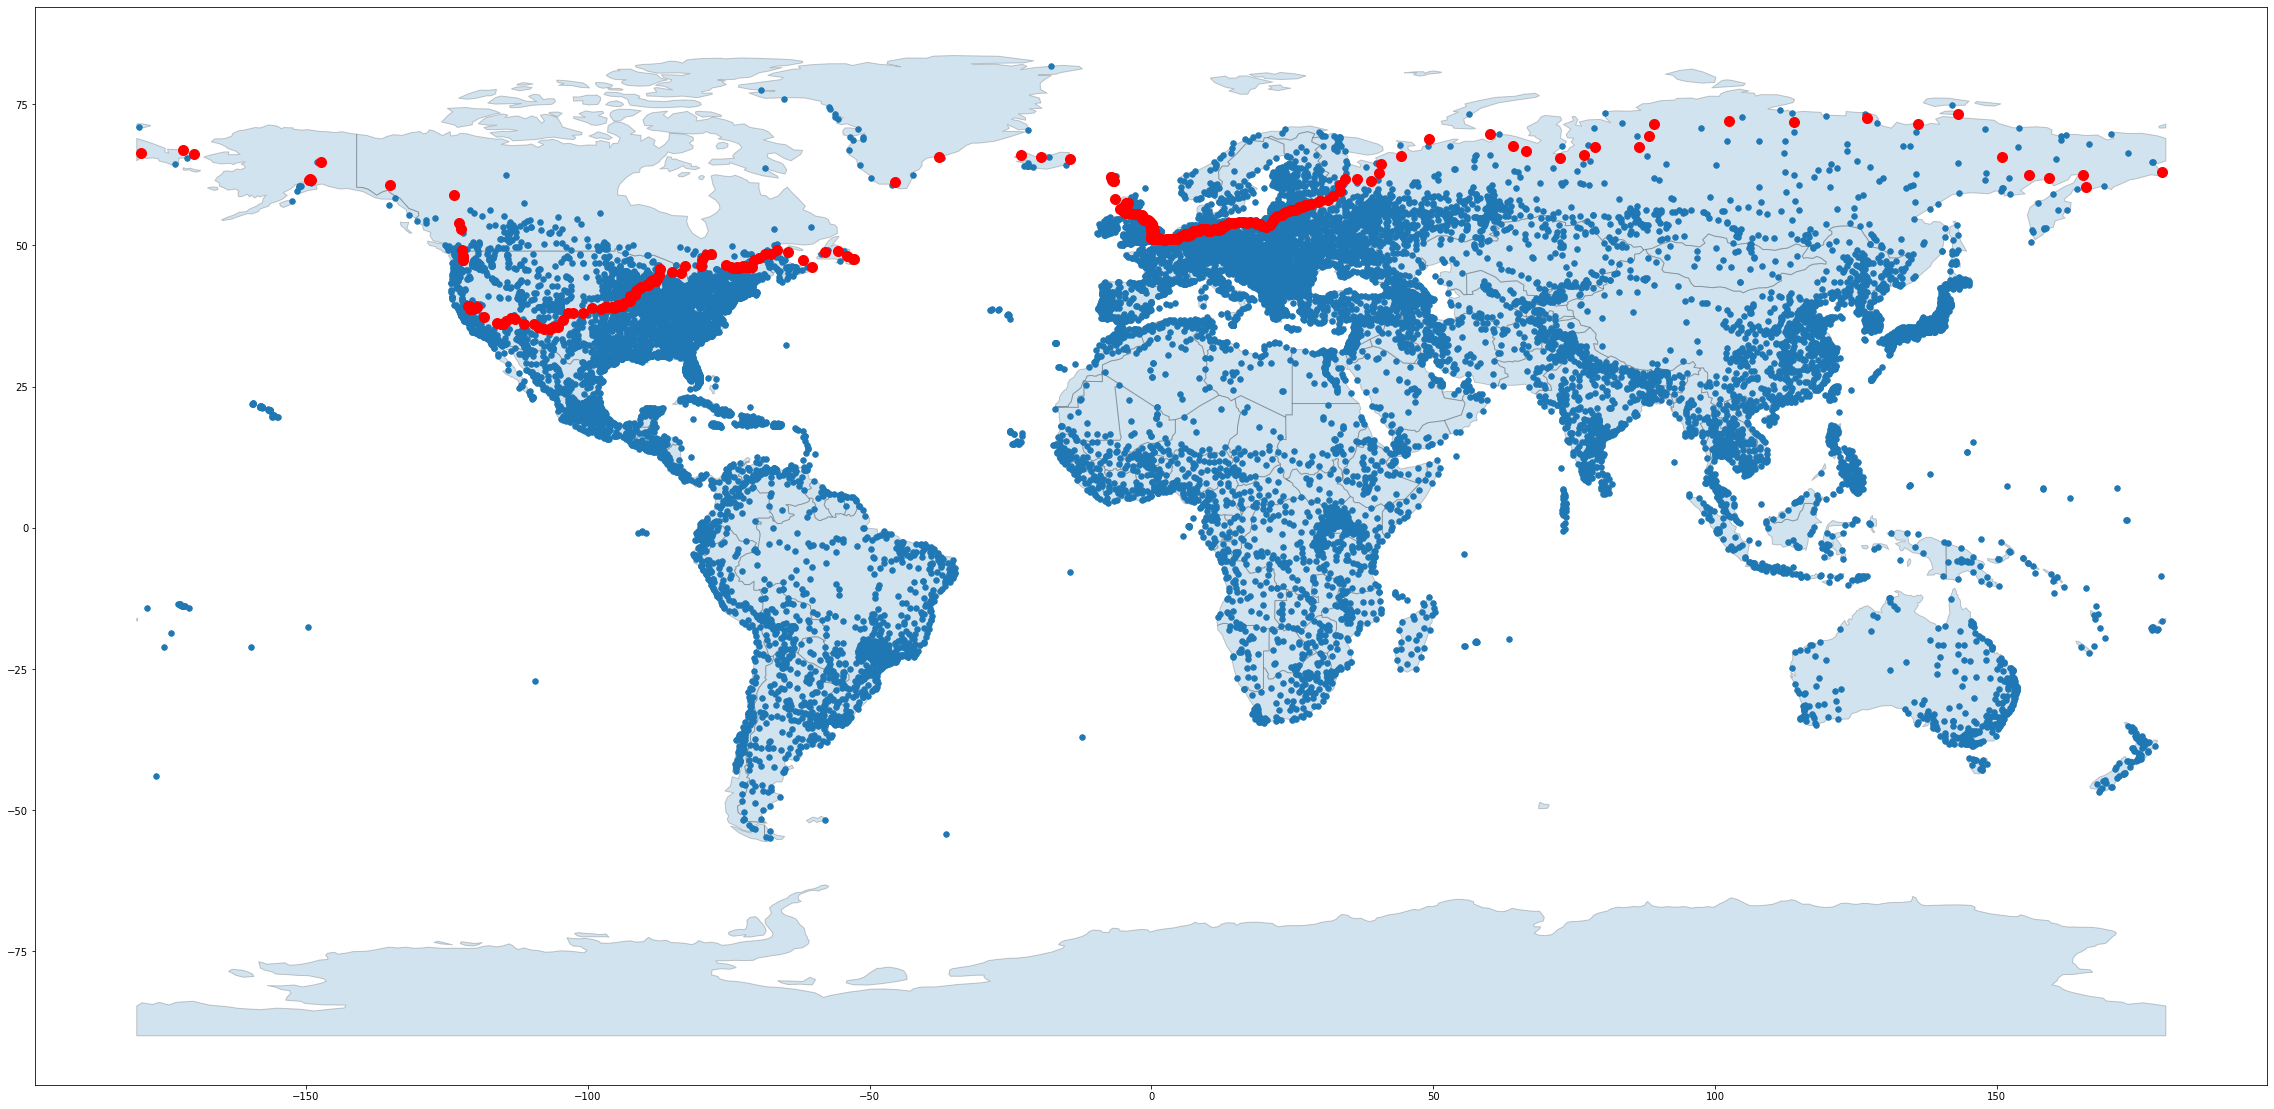

In [32]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
ax = world.plot(figsize=(40, 40), alpha=0.2, edgecolor='k')
ax.scatter(df.iloc[:,3], df.iloc[:,2], s=30)
ax.scatter(complete_journey.iloc[:,2], complete_journey.iloc[:,1], s=100, c='red')
plt.show()

### Mappa interattiva

In [33]:
world_map = folium.Map(location=[0,120], zoom_start=1)

In [34]:
for v in range(12972,df.shape[0]):
    df.iloc[v,3] += 360

In [35]:
datapoints = folium.map.FeatureGroup()
for v in df.iloc[O].iterrows():
    datapoints.add_child(
           folium.vector_layers.CircleMarker(
            [v[1][2:4]['lat'], v[1][2:4]['lng']],
            radius=1, # set the markers width
            color='green',
            fill=True,
            fill_color='white',
            fill_opacity=.2 )
    )
    
lats = list(df.iloc[O,2])
lngs = list(df.iloc[O,3])
labels = list(df.iloc[O,0])

for lat, lng, label in zip(lats, lngs, labels):
    folium.Marker([lat, lng], popup=label,).add_to(world_map)
    
world_map.add_child(datapoints)    

## The End